In [1]:
import csv
import numpy as np
import pandas as pd
import utils 
import seaborn as sns

from scipy.optimize import minimize, LinearConstraint
from scipy.special import softmax

In [2]:
data = np.genfromtxt('repeated_data.csv', delimiter=',', dtype=str)
data = np.delete(data, 0, 0)

In [3]:
data.shape

(28, 17)

In [4]:
new_data = []

# turn each game into entry in this array

def remove_blank(l):
    return list(filter(lambda a: a != '', l))

def replace_letters(l):
   return [[1,0] if x=='c' else [0, 1] for x in l]

for i in range(0, data.shape[0], 2):
    p1 = data[i]
    p2 = data[i+1]

    game = int(p1[0])
    player1 = p1[2]
    player2 = p2[2]
    p1_actions = np.array(replace_letters(remove_blank(p1[3:]))).T
    p2_actions =  np.array(replace_letters(remove_blank(p2[3:]))).T
   
    actions =  [p1_actions, p2_actions]

    new_data.append([game, player1, player2, actions])


In [5]:
df = pd.DataFrame(new_data)
df.columns = ['Game', 'Player_1', 'Player_2', 'Actions']

In [6]:
df.head()

,Game,Player_1,Player_2,Actions
0,0,Faisal,Bharathvaj,"[[[0, 1, 1, 1, 0], [1, 0, 0, 0, 1]], [[1, 0, 1..."
1,1,Yuan,Dagmar,"[[[1, 0, 0], [0, 1, 1]], [[1, 1, 0], [0, 0, 1]]]"
2,2,Ehsan,Mohammend,"[[[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0,..."
3,3,Tao,Rohini,"[[[0, 1, 0, 1, 1], [1, 0, 1, 0, 0]], [[1, 0, 0..."
4,4,Anita,Greg,"[[[1, 1, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 1]..."


In [7]:
plays = np.zeros((2,2))

for i, row in df.iterrows():
    actions = row.Actions
    for round in range( actions[0].shape[1]): # iterate over length of each game 
        s1 = actions[0][:, round]
        s2 = actions[1][:, round]
        p_outcomes = utils.p_outcomes([s1, s2])
        plays += p_outcomes
      
# frequency of each
plays/np.sum(plays)

array([[0.30232558, 0.18604651],
       [0.26744186, 0.24418605]])

<AxesSubplot:>

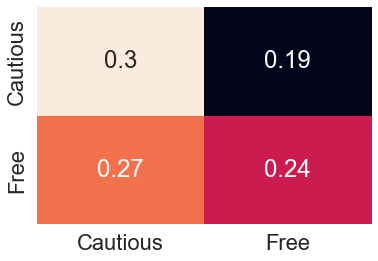

In [8]:
x_axis_labels = ['Cautious', 'Free']
y_axis_labels = ['Cautious', 'Free']
sns.set(font_scale=2) 
sns.heatmap(plays/np.sum(plays), annot=True, cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)


In [9]:
def p_traj(a, s):
    '''
    Returns the probability of a sequence of actions
    a being sampled from strategy s.

    Paramters:
        a : (np.Array) 2 x n array of actions chosen
        s : (np.Array) 2 x n array of strategies 
    '''

    assert a.shape == s.shape
    L = a.shape[1]
    prod = 1
    for l in range(L):
        idx = np.where(a[:, l])
        prod *= s[:, l][idx][0]

    return prod

In [10]:
data = list(df.Actions)
traj = data[0][0][:, 0:3]
s = np.array([[0.9, 0.1], [0.6, 0.4], [.3, .7] ]).T
assert p_traj(traj, s) == 0.018

In [11]:
def p_outcomes(s):
    '''
    returns a probability distribution over outcomes
    '''
    p = s[0]
    for s_i in s[1:]:
        p =  np.multiply.outer(p, s_i)
    return p

def expected_utility(s, payoffs):
    '''
    Gets the expected utilitiy for a player under strategy profile s
    
    Parameters
        s : (list) list where S[i] gives the probability of player i playing each action
        payoffs: (np.array) payoffs for i
    Returns
        eu : (float) expected utility for i
    '''
    p = p_outcomes(s)
    return np.sum(np.multiply(p, payoffs))


In [12]:
np.ones(3)[0:-1]

array([1., 1.])

In [36]:
np.ones((2, 8)) / (np.ones(8)*2)


array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [110]:
def ll_uniform( dataset):
    ll = 0
    for play in dataset: 
        for player in range(2):
            traj = play[player]
            s = np.ones_like(traj) / np.ones(traj.shape[1])*2
            ll += np.log(p_traj(traj, s))
    return -ll

ll_uniform(data)

-119.2213150563106

In [177]:
class Level_K_Model:
    def __init__(self, K, h):
        self.K = K
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -2]])
        self.alphas = None
        self.h = h # the history length


    def log_likelihood_independent(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood. This assumes a players level may change as the game goes on

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        
        alphas = params[0:-1]
        lambda_ = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    
                    pred_s = self.predict_traj(traj, other_traj, self.K, lambda_, overall=True, alphas=alphas)  
                    L = traj.shape[1] #length of trajectory
                 
                    for l in range(L):
                        idx = np.where(traj[:, l])
                        ll += np.log(pred_s[:, l][idx][0]+0.0001)

    
        return -ll # since we are minimizing the negative log likelihood



    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:-2]
        lambda_ = params[-2] 
        kappa  = params[-1] 
       

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, k in enumerate(range(self.K+1)): # condition on a specific value of k for a player
                    alpha_k = alphas[i]
    
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    pred_s = self.predict_traj(traj, other_traj, k, lambda_, kappa)
                    
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    
                    sum += alpha_k * prob # this could be 0, so small epsilon added

                ll += np.log(sum)
                #print(np.log(sum))

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(self.K+3) # +2 since level 0 and the lambda parameter, kappa parameter
        params[0] = 1 # inital guess is that all players are level 0
        params[-2] = 5 # intial guess for lambda
        params[-1] = 0.5 # intial guess for kappa

        const_arr = np.ones(self.K+3)
        const_arr[-1] = 0
        const_arr[-2] = 0
        #print(const_arr)
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(self.K+1)]
        bnds.append((0, 1000)) 
        bnds.append((0, 1)) 
        #print(bnds)

        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful
        self.alphas = result.x[0:-1]
        self.lambda_ = result.x[-1]
        ll = result.fun
        return ll


    def predict_traj(self, traj, other_traj, K, lambda_, kappa, overall=False, alphas=None):
        '''
        Returns straetgy predictions against other player
        
        '''
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h-1):
                l.append(l[i-1]*kappa)

            l.append(1- np.sum(l))
            assert np.sum(l) == 1
            return np.flip(np.array(l)) # should be flipped

        L = other_traj.shape[1]
        pred_i = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for i
        pred_other = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for other player

        for l in range(L):
            # first determine level 0 strategy 
            start_hist_idx = max(l-self.h, 0)
            end_hist_idx = l

            if l == 0: # there is no history, so level-0 strategies are uniform
                lvl_0_s_i = np.ones((2)) / 2
                lvl_0_s_other = np.ones((2)) / 2
            else:
                hist_i = traj[:, start_hist_idx:end_hist_idx] # limited history of i's actions
                hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions

                w = get_weights(hist_i.shape[1], kappa)
                lvl_0_s_i = np.dot(hist_i, w)
                lvl_0_s_other= np.dot(hist_other, w)


            # These become the level 0 strategies
            pred_i[:, 0, l] = lvl_0_s_i
            pred_other[:, 0, l] = lvl_0_s_other

            # Now, for higher levels:
            for k in range(1, K+1):
                pred_i[:, k, l] = self.compute_BR(pred_other[:, k-1, l], lambda_)
                pred_other[:, k, l] = self.compute_BR(pred_i[:, k-1, l], lambda_)
 

        if overall: # if return the overall prediction
            assert alphas is not None
            pred_i_ = np.zeros((2, L))

            for l in range(L):
                pred_i_[:, l] = np.matmul(pred_i[:, :, l], alphas)
            pred_i = pred_i_
     
        else:
            pred_i = np.squeeze(pred_i[:, K, :]) # only return the level K predictions


        if K == 0:
            return np.ones((2, L)) / (np.ones(L)*2)
        else:
            return pred_i   
        
        
    def predict_traj_new(self, traj, other_traj, K, lambda_, overall=False, alphas=None, gamma=0.5): 
        '''
        sdfsd
        
        '''
        L = other_traj.shape[1]
        pred_i = np.zeros((2, L)) # level-k prediction for each stage game for i
        pred_other = np.zeros((2, L)) # level-k prediction for each stage game for other player

        def level_k_strat(lvl_0_p0, lvl_0_p1, k):

            nonlocal lambda_
            if k == 0:
                return [lvl_0_p0, lvl_0_p1]

            lvl_kminus1_p0 = lvl_0_p0
            lvl_kminus1_p1 = lvl_0_p1
            for k in range(1, k+1):
                lvl_k_p0 = self.compute_BR(lvl_kminus1_p1, lambda_)
                lvl_k_p1 = self.compute_BR(lvl_kminus1_p0, lambda_)
                lvl_kminus1_p0 = lvl_k_p0
                lvl_kminus1_p1 = lvl_k_p1

            return [lvl_k_p0, lvl_k_p1]


        for l in range(L):
            # first determine level 0 strategy 
            # for each action, compute BR in next round assuming opponent level-k responds
            
            # if action 0

            if l == 0:
                next_s = level_k_strat(np.array([1,0]), np.array([0.5, 0.5]), K) # could replace this with history?
                eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([next_s[0], next_s[1]], self.payoffs[0])

                # if action 1
                next_s = level_k_strat(np.array([0,1]), np.array([0.5, 0.5]), K)
                eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0])+ gamma*expected_utility([next_s[0], next_s[1]], self.payoffs[0])
           
            else:
            
                s_this = level_k_strat(traj[:, l-1], other_traj[:, l-1], K)

                next_s = level_k_strat(np.array([1,0]), s_this[1], K)  
                eu_0 = expected_utility([np.array([1,0]), s_this[1] ], self.payoffs[0]) + gamma*expected_utility([next_s[0], next_s[1]], self.payoffs[0])

                # if action 1
                next_s = level_k_strat(np.array([0,1]), s_this[1], K) 
                eu_1 = expected_utility([np.array([0,1]), s_this[1]], self.payoffs[0]) + gamma*expected_utility([next_s[0], next_s[1]], self.payoffs[0]) 
    

            pred_i[:, l]  = softmax(lambda_* np.array([eu_0, eu_1]))
        return pred_i   

    def compute_BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])
        #print('EU 0: {}'.format( eu_0))

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])

        #print('EU 1: {}'.format( eu_1))

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


In [166]:
m = Level_K_Model(2, 2)

m.log_likelihood([1/2, 1/2, , 1, 0.7], data)

127.46976339824258

In [179]:

m = Level_K_Model(2, 2)
ll = m.fit(data)

     fun: 119.2213150563106
     jac: array([-28.        , -12.06767845, -27.84967232,   0.        ,
         0.        ])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1. , 0. , 0. , 5. , 0.5])


In [175]:
t2

array([[1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1]])

In [176]:
t1 = data[0][0]
t2 = data[0][1]
m.predict_traj(t2, t1, 2, 1.15, 0.65 )

array([[0.5       , 0.64494106, 0.45104967, 0.58638233, 0.41361767],
       [0.5       , 0.35505894, 0.54895033, 0.41361767, 0.58638233]])

In [170]:
losses = []
for h in range(4, 10):
    for k in range(1, 4):
        m = Level_K_Model(k, h)

        #m.log_likelihood([1/2, 1/2, 0, 1, 0.7], data)
        ll = m.fit(data)
        losses.append(ll)

     fun: 119.2213150563106
     jac: array([-28.        , -15.49908161,   0.        ,   0.        ])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1. , 0. , 5. , 0.5])
     fun: 115.4884639062245
     jac: array([-2.76285419e+01, -1.63381367e+01, -2.80000000e+01, -2.86102295e-05,
        6.96182251e-05])
 message: 'Optimization terminated successfully'
    nfev: 176
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([0.00000000e+00, 2.07195658e-13, 1.00000000e+00, 1.15683749e+00,
       7.31512559e-01])
     fun: 115.48846390638656
     jac: array([-2.76286030e+01, -1.63381386e+01, -2.80000000e+01, -2.32745676e+01,
        9.44137573e-05,  4.95910645e-05])
 message: 'Optimization terminated successfully'
    nfev: 197
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([4.09190665e-13, 0.00000000e+00, 1.00000000e+00, 1.46131390e-15,
       1.15684462e+00, 7.31511180e-0

AssertionError: 

In [32]:
class CH_Model(Level_K_Model):

    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:-1]
        lambda_ = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, k in enumerate(range(self.K+1)): # condition on a specific value of k for a player
                    alpha_k = alphas[i]
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player   
                          
                    pred_s = self.predict_traj(traj, other_traj, k, lambda_, alphas)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_k * (prob + 0.001) # this could be 0, so small epsilon added

                assert sum != 0
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood

    def fit(self, dataset):
        params = np.zeros(self.K+2) # +2 since level 0 and the lambda parameter
        params[0] = 1 # inital guess is that all players are level 0
        params[-1] = 5 # intial guess for lambda

        const_arr = np.ones(self.K+2)
        const_arr[-1] = 0
        #print(const_arr)
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(self.K+1)]
        bnds.append((0, 1000)) # no bounds for lambda
  
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful
        self.alphas = result.x[0:-1]
        self.lambda_ = result.x[-1]
        #ll = result.fun
        #return ll, self.alphas


    def predict_traj(self, traj, other_traj, K, lambda_, alphas):
        '''
        Returns straetgy predictions against other player
        
        '''
        L = other_traj.shape[1]
        pred_i = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for i
        pred_other = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for other player

        for l in range(L):
            # first determine level 0 strategy 
            start_hist_idx = max(l-self.h, 0)
            end_hist_idx = l

            if l == 0: # there is no history, so level-0 strategies are uniform
                lvl_0_s_i = np.ones((2)) / 2
                lvl_0_s_other = np.ones((2)) / 2
            else:
                hist_i = traj[:, start_hist_idx:end_hist_idx] # limited history of i's actions
                hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions
                
                lvl_0_s_i = np.sum(hist_i, axis=1)/np.sum(hist_i) # average strategy of i in history
                lvl_0_s_other = np.sum(hist_other, axis=1)/np.sum(hist_other) # average strategy of -i in history

            # These become the level 0 strategies
            pred_i[:, 0, l] = lvl_0_s_i
            pred_other[:, 0, l] = lvl_0_s_other

            # Now, for higher levels:
            for k in range(1, K+1):
                if np.sum(alphas[0:k]) != 0:
                    s_other = np.matmul(pred_other[:, 0:k, l], alphas[0:k]) / np.sum(alphas[0:k])
                    s_i = np.matmul(pred_i[:, 0:k, l], alphas[0:k]) / np.sum(alphas[0:k])
                else:
                    s_other = np.matmul(pred_other[:, 0:k, l], np.ones(k)/k) 
                    s_i = np.matmul(pred_i[:, 0:k, l], np.ones(k)/k) 
                    
                pred_i[:, k, l] = self.compute_BR(s_other, lambda_)  
                pred_other[:, k, l] = self.compute_BR(s_i, lambda_)
 

        pred_i = np.squeeze(pred_i[:, K, :]) # only return the level K predictions
        return pred_i

In [28]:
pi = np.array([[0.3, 0.7], [0.5, 0.5], [0.9, 0.1]]).T
w = [0.2, 0.3, 0.3]
np.matmul(pi, w) / np.sum(w )

array([0.6, 0.4])

In [33]:
m = CH_Model(3, 2)

t1 = data[0][0]
t2 = data[0][1]

r = m.fit(data)

     fun: 106.50696840687966
     jac: array([-27.99727345, -28.00016499, -28.00016499, -28.00016499,
         5.0526247 ])
 message: 'Optimization terminated successfully'
    nfev: 82
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([5.69200713e-02, 2.81243047e-08, 5.69888277e-01, 3.73191623e-01,
       0.00000000e+00])


In [ ]:
# reason about future rewards

In [181]:
class Temporal_Model:
    def __init__(self, h=1):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -2]])
        self.alphas = None
        self.h = h # the history length



    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:3] # frequency of different risk types in population
        gammas = params[3:6] # parameter of risk types in population
        lambda_ = params[-1] 
      

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, alpha_gamma in enumerate(alphas): # condition on a specific type of  player
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    gamma = gammas[i]
                    pred_s = self.predict_traj(traj, other_traj, lambda_, gamma)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_gamma * (prob) # this could be 0, so small epsilon added
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(7) # +2 since level 0 and the lambda parameter
    
        for i in range(3):
            params[i] = 1/3

        params[3] = 0.5
        params[4] = 1
        params[5] = 2
        params[6] = 1 # intial guess for lambda

        const_arr = np.zeros(7)
        for i in range(3):
            const_arr[i] = 1

       
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(3)]
       
        bnds.append((-1000, 1))
        bnds.append((1, 1))
        bnds.append((1, 1000))
        bnds.append((0, 1000)) # no bounds for lambda
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful
    
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''
        L = other_traj.shape[1]
        pred_i = np.zeros((2, L)) # level-k prediction for each stage game for i

        for l in range(L):
            if l == 0:
                # if action 0
                s_other_next = self.BR(np.array([1,0]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                # if action 1
                s_other_next = self.BR(np.array([0,1]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
           
            else:
                # if action 0
                s_other_curr = self.BR(traj[:, l-1], lambda_)
                #print('What I think the opponent will play this round')
                #print( s_other_curr)
                s_other_next = self.BR(np.array([1,0]), lambda_)
               # print('What I think the opponent will play next round')
               # print(s_other_next)
                s_i_next = self.BR(s_other_next, lambda_)
               # print('What I will play next round')
               # print(s_i_next)
                eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                # if action 1
                s_other_curr = self.BR(traj[:, l-1], lambda_)
                s_other_next = self.BR(np.array([0,1]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])


                #print(eu_0)
              #  print(eu_1)
            pred_i[:, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

        return pred_i   


    def BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy profile of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])


        # if eu_0 >= eu_1:
        #     return np.array([1,0])
        # else:
        #     return np.array([0,1])

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


In [182]:
m = Temporal_Model()

t1 = data[0][0]
t2 = data[0][1]


# print(t1)
# print(m.predict_traj(t1, t2, 2, 1000 ))
# print(t2)
# # m.predict_traj(t1, t2, 2, 5, overall=True, alphas=[0, 1, 0])

#   alphas = params[0:3] # frequency of different risk types in population
#   gammas = params[3:6] # parameter of risk types in population
#   lambda_ = params[-1] 

# print(m.predict_traj(t2, t1, 2, 1000))
r = m.fit(data)

     fun: 114.69670141201314
     jac: array([-2.80003872e+01, -2.75060768e+01, -2.79992981e+01, -3.11851501e-04,
                   nan,  6.11305237e-04,  5.21087646e-03])
 message: 'Optimization terminated successfully'
    nfev: 155
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 6.42297455e-01,  5.88386355e-16,  3.57702545e-01, -2.08624873e+00,
        1.00000000e+00,  2.32798801e+00,  5.71300232e-01])


In [ ]:
# reason about future and I have a level of reasoning

In [188]:
class Temporal_Level_Model:
    def __init__(self, h=1):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -2]])
        self.alphas = None
        self.h = h # the history length



    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alpha_ks = params[0:3] #
        gamma = params[3] # parameter of risk types in population
        lambda_ = params[4] 
        kappa = params[5]
      

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for k, alpha_k in enumerate(alpha_ks):
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, k, kappa)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_k * (prob) # this could be 0, so small epsilon added
            
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(6) # +2 since level 0 and the lambda parameter
    

        for i in range(3):
            params[i] = 1/3

        params[3] = 1 # gamma 
        params[4] = 1 # lambda
        params[4] = 0.5 # kappa

        const_arr = np.zeros(6)
        
        for i in range(3):
            const_arr[i] = 1
        constraint = LinearConstraint(const_arr, lb=1, ub=1)

        bnds = [(0, 1) for x in range(3)]

        bnds.append((0, 100))
        bnds.append((0, 100))
        bnds.append((0, 1))
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful
    
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma, k, kappa): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''
        def level_k_strat(lvl_0_p0, lvl_0_p1, k):
            nonlocal lambda_
            if k == 0:
                return [lvl_0_p0, lvl_0_p1]

            lvl_kminus1_p0 = lvl_0_p0
            lvl_kminus1_p1 = lvl_0_p1

            for k in range(1, k+1):
                lvl_k_p0 = self.compute_BR(lvl_kminus1_p1, lambda_)
                lvl_k_p1 = self.compute_BR(lvl_kminus1_p0, lambda_)
                lvl_kminus1_p0 = lvl_k_p0
                lvl_kminus1_p1 = lvl_k_p1

            return [lvl_k_p0, lvl_k_p1]


        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h-1):
                l.append(l[i-1]*kappa)

            l.append(1- np.sum(l))
            assert np.sum(l) == 1
            return np.array(l)



        L = other_traj.shape[1]
        pred_i = np.zeros((2, L)) # level-k prediction for each stage game for i

        for l in range(L):
           
            if l == 0:
                pred_i[:, l] = np.array([0.5, 0.5])

            else:
                if k == 0:
                    pred_i[:, l] = np.array([0.5, 0.5])

                elif k == 1:
                    start_hist_idx = max(l-self.h, 0)
                    end_hist_idx = l
                 
                    hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions
                    
                    w = get_weights(hist_other.shape[1], kappa)

                    lvl_0_s_other = np.dot(hist_other, w)
                    pred_i[:, l] = self.BR(lvl_0_s_other, lambda_)

                else:
                    start_hist_idx = max(l-self.h, 0)
                    end_hist_idx = l
                  
                    hist_i = traj[:, start_hist_idx:end_hist_idx] # limited history of i's actions
                    hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions
                    

                    def eu(action, hist_i, hist_other):
                        nonlocal gamma,l

                        w = get_weights(hist_other.shape[1], kappa)
                        lvl_0_s_i = np.dot(hist_i, w)
                        lvl_0_s_other = np.dot(hist_other, w)

                        #lvl_0_s_i = np.sum(hist_i, axis=1)/np.sum(hist_i) # average strategy of i in history
                        #lvl_0_s_other = np.sum(hist_other, axis=1)/np.sum(hist_other) # average strategy of -i in history

                        # aciton 0:
                        hist_i_new = np.c_[hist_i, action] # limited history of i's actions
                        if hist_i_new.shape[0] > self.h:
                            hist_i_new = np.delete(hist_i_new, 0, axis=1)

                        w = get_weights(hist_i_new.shape[1], kappa)
                        lvl_0_s_i_new = np.dot(hist_i_new,  w) # average strategy of i in history
                    
                        eu = expected_utility(action, self.BR(lvl_0_s_i, lambda_)) + gamma*expected_utility( lvl_0_s_i_new , self.BR(lvl_0_s_i_new, lambda_))
                        return eu

                    eu_0 = eu(np.array([1,0]), hist_i, hist_other)
                    eu_1 = eu(np.array([0,1]), hist_i, hist_other)
                    pred_i[:, l] = softmax(np.array([eu_0, eu_1])*lambda_)

        return pred_i
        
    def BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy profile of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])


        # if eu_0 >= eu_1:
        #     return np.array([1,0])
        # else:
        #     return np.array([0,1])

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


In [94]:
def get_weights(h, kappa):
    if h == 1:
        return np.ones(1)
    
    l = [1-kappa]
    
    for i in range(1, h-1):
        l.append(l[i-1]*kappa)

    l.append(1- np.sum(l))
    assert np.sum(l) == 1
    return np.array(l)

In [95]:
get_weights(4, 0.3)

array([0.7  , 0.21 , 0.063, 0.027])

In [189]:
m = Temporal_Level_Model(h = 2)
m.fit(data)
t1 = data[0][0]
t2 = data[0][1]


# print(t1)
#print(m.predict_traj(t1, t2, lambda_=1, gamma=1, k=1))
# print(t2)
# # m.predict_traj(t1, t2, 2, 5, overall=True, alphas=[0, 1, 0])

#m.log_likelihood( [1, 0, 0, 1, 1, 0.25], data)
# print(m.predict_traj(t2, t1, 2, 1000))


     fun: 119.2213150563104
     jac: array([-28.0000001, -28.       , -28.       ,   0.       ,   0.       ,
         0.       ])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.5, 0. , 0.5, 1. , 0. , 0. ])
